In [30]:
!git clone https://github.com/LenaNguyen/AutonomousCar.git

fatal: destination path 'AutonomousCar' already exists and is not an empty directory.


In [31]:
!ls AutonomousCar

Assets	AutoDrive.ipynb  CarAI	lanes.py  TrafficSignDetection.ipynb


In [32]:
!pip3 install imgaug

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random
from imgaug import augmenters as iaa

In [34]:
datadir = "AutonomousCar/CarAI/Data"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\center_2020_01_25_02_05_43_520.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\left_2020_01_25_02_05_43_520.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\right_2020_01_25_02_05_43_520.jpg,0.0,0.0,0,1.736730
1,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\center_2020_01_25_02_05_43_630.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\left_2020_01_25_02_05_43_630.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\right_2020_01_25_02_05_43_630.jpg,0.0,0.0,0,1.715838
2,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\center_2020_01_25_02_05_43_733.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\left_2020_01_25_02_05_43_733.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\right_2020_01_25_02_05_43_733.jpg,0.0,0.0,0,1.698621
3,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\center_2020_01_25_02_05_43_835.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\left_2020_01_25_02_05_43_835.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\right_2020_01_25_02_05_43_835.jpg,0.0,0.0,0,1.681575
4,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\center_2020_01_25_02_05_43_936.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\left_2020_01_25_02_05_43_936.jpg,C:\Users\Nguye\Documents\Online Courses\OpenCV\CarAI\Data\IMG\right_2020_01_25_02_05_43_936.jpg,0.0,0.0,0,1.664701


In [35]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_01_25_02_05_43_520.jpg,left_2020_01_25_02_05_43_520.jpg,right_2020_01_25_02_05_43_520.jpg,0.0,0.0,0,1.736730
1,center_2020_01_25_02_05_43_630.jpg,left_2020_01_25_02_05_43_630.jpg,right_2020_01_25_02_05_43_630.jpg,0.0,0.0,0,1.715838
2,center_2020_01_25_02_05_43_733.jpg,left_2020_01_25_02_05_43_733.jpg,right_2020_01_25_02_05_43_733.jpg,0.0,0.0,0,1.698621
3,center_2020_01_25_02_05_43_835.jpg,left_2020_01_25_02_05_43_835.jpg,right_2020_01_25_02_05_43_835.jpg,0.0,0.0,0,1.681575
4,center_2020_01_25_02_05_43_936.jpg,left_2020_01_25_02_05_43_936.jpg,right_2020_01_25_02_05_43_936.jpg,0.0,0.0,0,1.664701


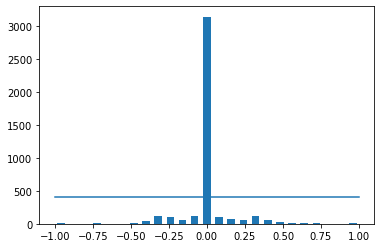

In [36]:
# Graph steering angles from data
num_bins = 25
samples_per_bin = 400 # set a max number of samples so that we don't bias the data
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4068
removed: 2744
remaining: 1324


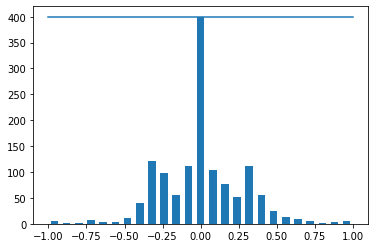

In [37]:
print('total data:', len(data))
remove_list = []

# loop through each steering angle range (bin) and keep the top 200,
# while adding all else to the remove list
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [38]:
# example of what's in data.iloc
print(data.iloc[1])

def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    # returns a set of data containg the center, left, and right 
    # images for the given steering angle
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  
  # convert lists to arrays
  image_paths = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_paths, steering

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_01_25_02_05_44_241.jpg
left        left_2020_01_25_02_05_44_241.jpg  
right       right_2020_01_25_02_05_44_241.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       1.61183                           
Name: 7, dtype: object


In [39]:
# randomly split data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1059
Valid Samples: 265


Text(0.5, 1.0, 'Validation Set')

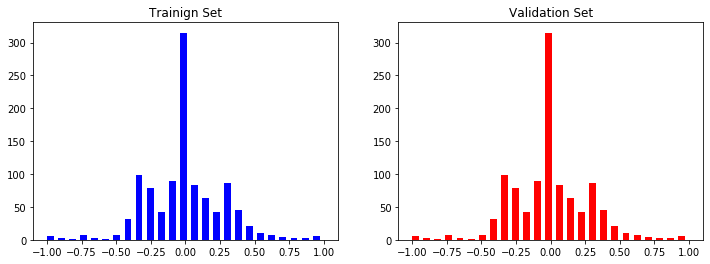

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Trainign Set')
axes[1].hist(y_train, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1, 'Zoomed Image')

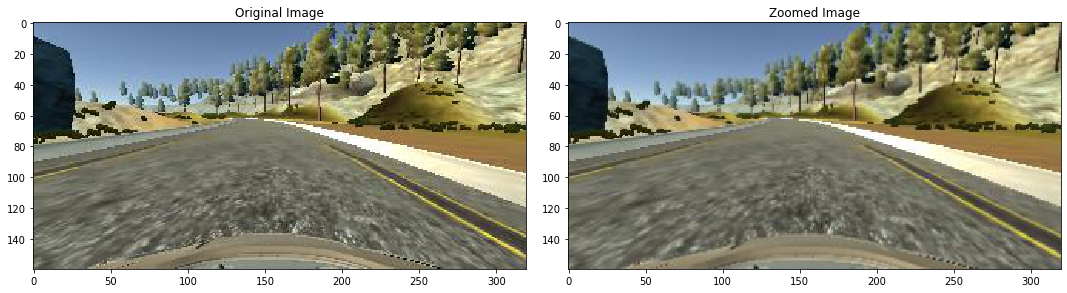

In [42]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y":(-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1, 'Panned Image')

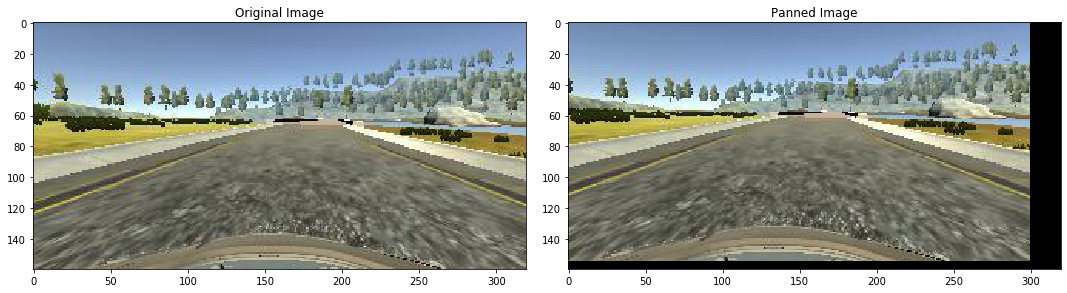

In [44]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1, 'Brightness altered image ')

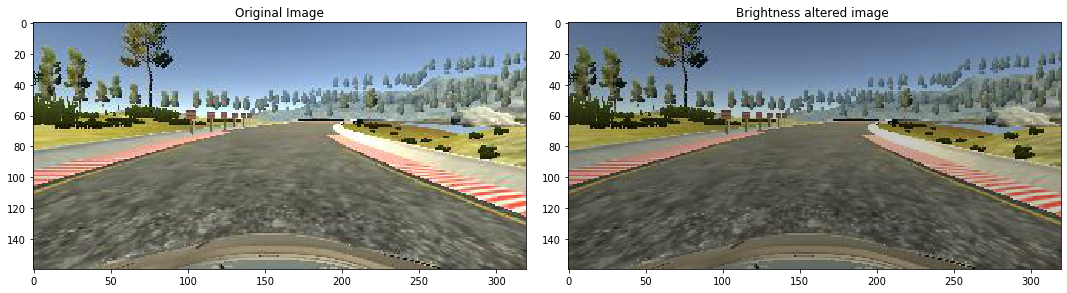

In [46]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1, 'Flipped Image - Steering Angle:-0.0842841')

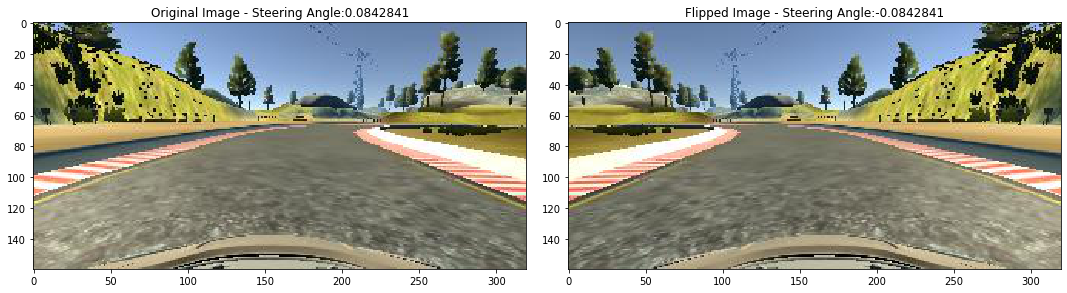

In [48]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image_paths[randnum])
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

In [50]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Preprocessing
def img_preprocess(img):
  img = img[ 60:135, :, :] #crop sky and hood of teh car from image because there details are not relevant
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # change to yuv coloring for nvidia model
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

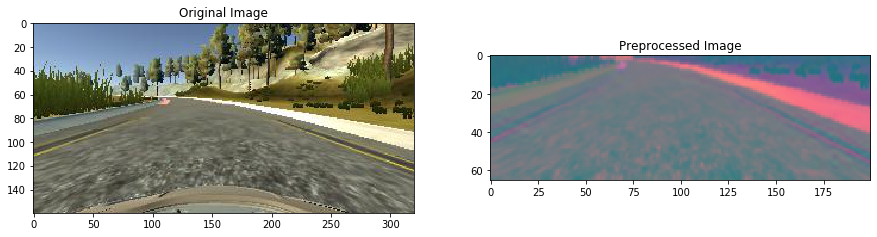

In [52]:
image = image_paths[80]
original_image = mpimg.imread(image)

preprocessed_image = img_preprocess(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      # only augment images when training
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  


Text(0.5, 1, 'Validation Image')

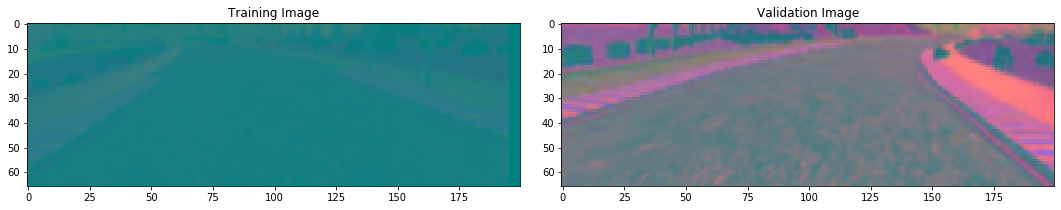

In [54]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
# Nvidia Model
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66, 200, 3), activation='relu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(1))

  model.compile(loss='mse', optimizer=Adam(lr=1e-4))
  return model


In [56]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), ac

In [57]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 181s 602ms/step - loss: 0.0778 - val_loss: 0.0589
Epoch 2/10
300/300 [==============================] - 175s 584ms/step - loss: 0.0756 - val_loss: 0.0591
Epoch 3/10
300/300 [==============================] - 176s 586ms/step - loss: 0.0748 - val_loss: 0.0587
Epoch 4/10
300/300 [==============================] - 176s 587ms/step - loss: 0.0739 - val_loss: 0.0591
Epoch 5/10
300/300 [==============================] - 175s 582ms/step - loss: 0.0757 - val_loss: 0.0594
Epoch 6/10
300/300 [==============================] - 174s 580ms/step - loss: 0.0740 - val_loss: 0.0599
Epoch 7/10
300/300 [==============================] - 175s 584ms/step - loss: 0.0738 - val_loss: 0.0597
Epoch 8/10
300/300 [==============================] - 175s 585ms/step - loss: 0.0760 - val_loss: 0.0593
Epoch 9/10
300/300 [==============================] - 177s 590ms/step - loss: 0.0759 - val_loss: 0.0581
Epoch 10/10
300/300 [==============================] - 175s 582m

Text(0.5, 0, 'Epoch')

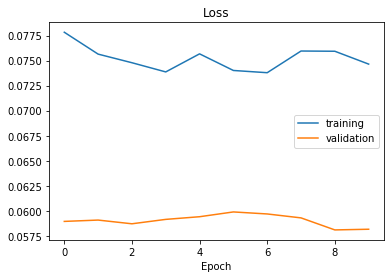

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')